In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
    df = pd.read_csv("C:/Users/GiladTK/Desktop/python/lvble/R01_final/ALL REPAYMENTS DATA .csv")

In [3]:
features = ["DAYS_SINCE_PREVIOUS_REPAYMENT", "USER_R01_PROP", "USER_NSF_PROP", "INSTALLMENT_PLAN_CHANGES", "PAYMENT_NUMBER", "TYPE", "WEEK_DAY_COLLECTED"]


In [4]:
df.USER_ID.unique().shape

(1288,)

## first deal with NA

In [5]:
df.isna().sum(axis=0)

AMOUNT                              0
BALANCE                             1
USER_ID                             0
STATUS                              0
RETURN_CODE                      8764
COLLECTION_FAILURE_REASON        8998
INSTITUTION_NAME                    1
TYPE                                0
PAYMENT_NUMBER                    419
STATE                             284
TENANT_PORTAL                       0
RISK_SCORE                        757
RENT_CYCLE_NUMBER                   0
ID                                  0
PAYMENT_NUMBER.1                  419
INSTALLMENT_PLAN_CHANGES            0
USER_NSF_PROP                       0
RENT_NSF_PROP                       0
USER_R01_PROP                    1284
DAYS_SINCE_PREVIOUS_REPAYMENT    1101
DAYS_SINCE_SUCCEEDED_PAYMENT     3329
DAYS_SINCE_FAILED_PAYMENT        6994
DAYS_SINCE_NSF                   7219
WEEK_DAY_COLLECTED                  0
HOUR_COLLECTED                      0
AGE                                 0
DIFF_D_REP_B

In [6]:
# DAYS_SINCE_PREVIOUS_REPAYMENT

# It is probably users first rent... lets fill with mean/median 
avg , med = df.DAYS_SINCE_PREVIOUS_REPAYMENT.mean(),df.DAYS_SINCE_PREVIOUS_REPAYMENT.median()
print(avg , med)
df.DAYS_SINCE_PREVIOUS_REPAYMENT[df.DAYS_SINCE_PREVIOUS_REPAYMENT.isna()] =  max([avg,med])

9.382170444472585 7.0


C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\4208640625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DAYS_SINCE_PREVIOUS_REPAYMENT[df.DAYS_SINCE_PREVIOUS_REPAYMENT.isna()] =  max([avg,med])


In [7]:
df.DAYS_SINCE_PREVIOUS_REPAYMENT.describe()

count    8998.000000
mean        9.382170
std         6.688089
min         0.000000
25%         6.000000
50%         8.000000
75%        11.000000
max       102.000000
Name: DAYS_SINCE_PREVIOUS_REPAYMENT, dtype: float64

In [8]:
# RETURN_CODE                 
# create target var & removing RETURN_CODE
df["is_R01"] = df.RETURN_CODE == 'R01'
df = df.drop(columns="RETURN_CODE")

In [9]:
df.isna().sum(axis=0)

AMOUNT                              0
BALANCE                             1
USER_ID                             0
STATUS                              0
COLLECTION_FAILURE_REASON        8998
INSTITUTION_NAME                    1
TYPE                                0
PAYMENT_NUMBER                    419
STATE                             284
TENANT_PORTAL                       0
RISK_SCORE                        757
RENT_CYCLE_NUMBER                   0
ID                                  0
PAYMENT_NUMBER.1                  419
INSTALLMENT_PLAN_CHANGES            0
USER_NSF_PROP                       0
RENT_NSF_PROP                       0
USER_R01_PROP                    1284
DAYS_SINCE_PREVIOUS_REPAYMENT       0
DAYS_SINCE_SUCCEEDED_PAYMENT     3329
DAYS_SINCE_FAILED_PAYMENT        6994
DAYS_SINCE_NSF                   7219
WEEK_DAY_COLLECTED                  0
HOUR_COLLECTED                      0
AGE                                 0
DIFF_D_REP_BAL                      1
DIFF_D_REP_R

In [10]:
# PAYMENT_NUMBER
# create combine_payments (if null then combined - replace null by 0)
df.combine_payments = df.PAYMENT_NUMBER.isnull()
df.PAYMENT_NUMBER[df.PAYMENT_NUMBER.isnull()] = 0

C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\1343640503.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.combine_payments = df.PAYMENT_NUMBER.isnull()
C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\1343640503.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.PAYMENT_NUMBER[df.PAYMENT_NUMBER.isnull()] = 0


In [11]:
# now add a dummy that indicates that its multipayments in a single repayment
df['is_more_the_1_payment'] = df.PAYMENT_NUMBER == 0 

In [12]:
df.isna().sum(axis=0)

AMOUNT                              0
BALANCE                             1
USER_ID                             0
STATUS                              0
COLLECTION_FAILURE_REASON        8998
INSTITUTION_NAME                    1
TYPE                                0
PAYMENT_NUMBER                      0
STATE                             284
TENANT_PORTAL                       0
RISK_SCORE                        757
RENT_CYCLE_NUMBER                   0
ID                                  0
PAYMENT_NUMBER.1                  419
INSTALLMENT_PLAN_CHANGES            0
USER_NSF_PROP                       0
RENT_NSF_PROP                       0
USER_R01_PROP                    1284
DAYS_SINCE_PREVIOUS_REPAYMENT       0
DAYS_SINCE_SUCCEEDED_PAYMENT     3329
DAYS_SINCE_FAILED_PAYMENT        6994
DAYS_SINCE_NSF                   7219
WEEK_DAY_COLLECTED                  0
HOUR_COLLECTED                      0
AGE                                 0
DIFF_D_REP_BAL                      1
DIFF_D_REP_R

In [13]:
# STATE - all under 100 count as other - Null as missing                       
df.STATE[df.STATE.isna()] = 'missing'

df.STATE[~df.STATE.isin(df.STATE.value_counts()[df.STATE.value_counts() > 100 ].index)] = "other_state"

df.STATE.value_counts()

C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\4278105140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.STATE[df.STATE.isna()] = 'missing'
C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\4278105140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.STATE[~df.STATE.isin(df.STATE.value_counts()[df.STATE.value_counts() > 100 ].index)] = "other_state"


TX             1383
other_state    1349
NY             1060
NJ              936
FL              729
CA              691
PA              410
IL              396
MD              313
GA              286
missing         284
OH              259
TN              206
NC              177
IN              161
WA              127
VA              118
SC              113
Name: STATE, dtype: int64

In [14]:
df.isna().sum(axis=0)

AMOUNT                              0
BALANCE                             1
USER_ID                             0
STATUS                              0
COLLECTION_FAILURE_REASON        8998
INSTITUTION_NAME                    1
TYPE                                0
PAYMENT_NUMBER                      0
STATE                               0
TENANT_PORTAL                       0
RISK_SCORE                        757
RENT_CYCLE_NUMBER                   0
ID                                  0
PAYMENT_NUMBER.1                  419
INSTALLMENT_PLAN_CHANGES            0
USER_NSF_PROP                       0
RENT_NSF_PROP                       0
USER_R01_PROP                    1284
DAYS_SINCE_PREVIOUS_REPAYMENT       0
DAYS_SINCE_SUCCEEDED_PAYMENT     3329
DAYS_SINCE_FAILED_PAYMENT        6994
DAYS_SINCE_NSF                   7219
WEEK_DAY_COLLECTED                  0
HOUR_COLLECTED                      0
AGE                                 0
DIFF_D_REP_BAL                      1
DIFF_D_REP_R

In [15]:
print(df.is_R01.mean())
print(df.is_R01[df.RISK_SCORE.isna() | df.USER_R01_PROP.isna()].mean())
print(df.is_R01[df.RISK_SCORE.isna()].mean())
print(df.is_R01[df.USER_R01_PROP.isna()].mean())

0.020115581240275616
0.018819938962360123
0.019815059445178335
0.018691588785046728


In [16]:
# AGE & NSF prop 
# change na to mean only 3 instances together
df.USER_NSF_PROP[df.USER_NSF_PROP.isna()] = df.USER_NSF_PROP.mean()
df.AGE[df.AGE.isna()] = df.AGE.mean()
df.isna().sum(axis=0)

C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\3394967152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.USER_NSF_PROP[df.USER_NSF_PROP.isna()] = df.USER_NSF_PROP.mean()
C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\3394967152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.AGE[df.AGE.isna()] = df.AGE.mean()


AMOUNT                              0
BALANCE                             1
USER_ID                             0
STATUS                              0
COLLECTION_FAILURE_REASON        8998
INSTITUTION_NAME                    1
TYPE                                0
PAYMENT_NUMBER                      0
STATE                               0
TENANT_PORTAL                       0
RISK_SCORE                        757
RENT_CYCLE_NUMBER                   0
ID                                  0
PAYMENT_NUMBER.1                  419
INSTALLMENT_PLAN_CHANGES            0
USER_NSF_PROP                       0
RENT_NSF_PROP                       0
USER_R01_PROP                    1284
DAYS_SINCE_PREVIOUS_REPAYMENT       0
DAYS_SINCE_SUCCEEDED_PAYMENT     3329
DAYS_SINCE_FAILED_PAYMENT        6994
DAYS_SINCE_NSF                   7219
WEEK_DAY_COLLECTED                  0
HOUR_COLLECTED                      0
AGE                                 0
DIFF_D_REP_BAL                      1
DIFF_D_REP_R

In [17]:
df.shape

(8998, 30)

In [18]:
df.USER_R01_PROP.describe() 

count    7714.000000
mean        0.017760
std         0.084296
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: USER_R01_PROP, dtype: float64

In [19]:
# null in R01 prop because there are not previous rents.. 

df.USER_ID.unique().shape[0] , df.USER_R01_PROP.isna().sum()

(1288, 1284)

In [20]:
df.USER_R01_PROP[df.USER_R01_PROP.isna()] = 0 

C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\1328848627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.USER_R01_PROP[df.USER_R01_PROP.isna()] = 0


In [21]:
df.isna().sum(axis=0)

AMOUNT                              0
BALANCE                             1
USER_ID                             0
STATUS                              0
COLLECTION_FAILURE_REASON        8998
INSTITUTION_NAME                    1
TYPE                                0
PAYMENT_NUMBER                      0
STATE                               0
TENANT_PORTAL                       0
RISK_SCORE                        757
RENT_CYCLE_NUMBER                   0
ID                                  0
PAYMENT_NUMBER.1                  419
INSTALLMENT_PLAN_CHANGES            0
USER_NSF_PROP                       0
RENT_NSF_PROP                       0
USER_R01_PROP                       0
DAYS_SINCE_PREVIOUS_REPAYMENT       0
DAYS_SINCE_SUCCEEDED_PAYMENT     3329
DAYS_SINCE_FAILED_PAYMENT        6994
DAYS_SINCE_NSF                   7219
WEEK_DAY_COLLECTED                  0
HOUR_COLLECTED                      0
AGE                                 0
DIFF_D_REP_BAL                      1
DIFF_D_REP_R

In [22]:
df = df.drop(columns=["USER_ID","RISK_SCORE","RENT_CYCLE_NUMBER","COLLECTION_FAILURE_REASON"])

In [23]:
print(df.DAYS_SINCE_NSF.median())
print(df.DAYS_SINCE_SUCCEEDED_PAYMENT.median())
print(df.DAYS_SINCE_FAILED_PAYMENT.median())

7.0
8.0
7.0


In [24]:

df.DAYS_SINCE_NSF[df.DAYS_SINCE_NSF.isna()] = df.DAYS_SINCE_NSF.median()

df.DAYS_SINCE_SUCCEEDED_PAYMENT[df.DAYS_SINCE_SUCCEEDED_PAYMENT.isna()] = df.DAYS_SINCE_SUCCEEDED_PAYMENT.median()

df.DAYS_SINCE_FAILED_PAYMENT[df.DAYS_SINCE_FAILED_PAYMENT.isna()] = df.DAYS_SINCE_FAILED_PAYMENT.median()


C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\1707081650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DAYS_SINCE_NSF[df.DAYS_SINCE_NSF.isna()] = df.DAYS_SINCE_NSF.median()
C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\1707081650.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DAYS_SINCE_SUCCEEDED_PAYMENT[df.DAYS_SINCE_SUCCEEDED_PAYMENT.isna()] = df.DAYS_SINCE_SUCCEEDED_PAYMENT.median()
C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\1707081650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [25]:
df = df.drop(columns=["PAYMENT_NUMBER.1"])

In [26]:
df = df[~ (df.BALANCE.isna() | df.INSTITUTION_NAME.isna() | df.DIFF_D_REP_BAL.isna())]

In [27]:
df2 = df.copy()

In [28]:
df.isna().sum()

AMOUNT                           0
BALANCE                          0
STATUS                           0
INSTITUTION_NAME                 0
TYPE                             0
PAYMENT_NUMBER                   0
STATE                            0
TENANT_PORTAL                    0
ID                               0
INSTALLMENT_PLAN_CHANGES         0
USER_NSF_PROP                    0
RENT_NSF_PROP                    0
USER_R01_PROP                    0
DAYS_SINCE_PREVIOUS_REPAYMENT    0
DAYS_SINCE_SUCCEEDED_PAYMENT     0
DAYS_SINCE_FAILED_PAYMENT        0
DAYS_SINCE_NSF                   0
WEEK_DAY_COLLECTED               0
HOUR_COLLECTED                   0
AGE                              0
DIFF_D_REP_BAL                   0
DIFF_D_REP_RENT                  0
DIFF_D_REP_CRE_COL               0
is_R01                           0
is_more_the_1_payment            0
dtype: int64

## now categorial features

In [29]:
df.dtypes

AMOUNT                             int64
BALANCE                          float64
STATUS                            object
INSTITUTION_NAME                  object
TYPE                              object
PAYMENT_NUMBER                   float64
STATE                             object
TENANT_PORTAL                     object
ID                                 int64
INSTALLMENT_PLAN_CHANGES           int64
USER_NSF_PROP                    float64
RENT_NSF_PROP                    float64
USER_R01_PROP                    float64
DAYS_SINCE_PREVIOUS_REPAYMENT    float64
DAYS_SINCE_SUCCEEDED_PAYMENT     float64
DAYS_SINCE_FAILED_PAYMENT        float64
DAYS_SINCE_NSF                   float64
WEEK_DAY_COLLECTED                 int64
HOUR_COLLECTED                     int64
AGE                                int64
DIFF_D_REP_BAL                   float64
DIFF_D_REP_RENT                    int64
DIFF_D_REP_CRE_COL                 int64
is_R01                              bool
is_more_the_1_pa

In [30]:
# whoops statuss other then failed and succeded are redandent no R01s !! 
((~((df.STATUS == "Failed") | (df.STATUS == "Succeeded"))) & (df.is_R01 == 1)).sum()

0

In [31]:
df = df[(((df.STATUS == "Failed") | (df.STATUS == "Succeeded")))]
df.shape

(8658, 25)

In [32]:
# drop STATUS column over data leakage (succful dont have R01s)
df = df.drop(columns="STATUS")

In [33]:
df.dtypes[df.dtypes == 'object' ]

INSTITUTION_NAME    object
TYPE                object
STATE               object
TENANT_PORTAL       object
dtype: object

In [34]:
# INSTITUTION_NAME
df.INSTITUTION_NAME[~df.INSTITUTION_NAME.isin(df.INSTITUTION_NAME.value_counts()[df.INSTITUTION_NAME.value_counts() > 100 ].index)] = "other_institution"
df.INSTITUTION_NAME.value_counts()

C:\Users\GiladTK\AppData\Local\Temp\ipykernel_65528\4183541407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.INSTITUTION_NAME[~df.INSTITUTION_NAME.isin(df.INSTITUTION_NAME.value_counts()[df.INSTITUTION_NAME.value_counts() > 100 ].index)] = "other_institution"


other_institution            2152
Chase                        1548
Bank of America              1021
Wells Fargo                   989
Chime                         667
Capital One                   646
Navy Federal Credit Union     570
TD Bank                       283
USAA                          203
Truist                        187
Huntington Bank               140
SoFi                          135
Regions Bank                  117
Name: INSTITUTION_NAME, dtype: int64

In [35]:
# INSTITUTION_NAME - dummiessssss
df = pd.concat([df,pd.get_dummies(df.INSTITUTION_NAME)], axis=1)


In [36]:
# INSTITUTION_NAME - byeeee
df = df.drop(columns="INSTITUTION_NAME")

In [37]:
# TYPE
df["is_on_demand"] = df.TYPE == "OnDemand"
df = df.drop(columns="TYPE")

In [38]:
# STATE
df = pd.concat([df,pd.get_dummies(df.STATE)], axis=1)


In [39]:
# TENANT_PORTAL
df = pd.concat([df,pd.get_dummies(df.TENANT_PORTAL)], axis=1)


In [40]:
df.dtypes[df.dtypes == 'object' ]

STATE            object
TENANT_PORTAL    object
dtype: object

In [41]:
df = df.drop(columns=["TENANT_PORTAL","STATE","ID"])

In [42]:
# oh yheaaaaaa
df.dtypes[df.dtypes == 'object' ]

Series([], dtype: object)

In [43]:
df.dtypes

AMOUNT                             int64
BALANCE                          float64
PAYMENT_NUMBER                   float64
INSTALLMENT_PLAN_CHANGES           int64
USER_NSF_PROP                    float64
RENT_NSF_PROP                    float64
USER_R01_PROP                    float64
DAYS_SINCE_PREVIOUS_REPAYMENT    float64
DAYS_SINCE_SUCCEEDED_PAYMENT     float64
DAYS_SINCE_FAILED_PAYMENT        float64
DAYS_SINCE_NSF                   float64
WEEK_DAY_COLLECTED                 int64
HOUR_COLLECTED                     int64
AGE                                int64
DIFF_D_REP_BAL                   float64
DIFF_D_REP_RENT                    int64
DIFF_D_REP_CRE_COL                 int64
is_R01                              bool
is_more_the_1_payment               bool
Bank of America                    uint8
Capital One                        uint8
Chase                              uint8
Chime                              uint8
Huntington Bank                    uint8
Navy Federal Cre

## Feature engeering and correlations

In [44]:
df["balance_amount_ratio"] = df.BALANCE / df.AMOUNT

In [45]:
corr = df.corr()
corr.is_R01.abs().sort_values(ascending=0,)

is_R01                           1.000000
USER_R01_PROP                    0.159660
DAYS_SINCE_PREVIOUS_REPAYMENT    0.137334
DAYS_SINCE_FAILED_PAYMENT        0.135245
USER_NSF_PROP                    0.132171
RENT_NSF_PROP                    0.130324
DAYS_SINCE_NSF                   0.107778
DIFF_D_REP_BAL                   0.107230
Capital One                      0.099836
DAYS_SINCE_SUCCEEDED_PAYMENT     0.071522
DIFF_D_REP_RENT                  0.068609
Chase                            0.055541
Chime                            0.054666
AMOUNT                           0.045572
GA                               0.038311
missing                          0.037659
AGE                              0.035478
WEEK_DAY_COLLECTED               0.033151
BALANCE                          0.032684
CA                               0.029764
is_on_demand                     0.029028
PAYMENT_NUMBER                   0.028986
IL                               0.026994
NY                               0

In [46]:
features = ["DAYS_SINCE_PREVIOUS_REPAYMENT","DAYS_SINCE_NSF","DAYS_SINCE_SUCCEEDED_PAYMENT","DAYS_SINCE_FAILED_PAYMENT","balance_amount_ratio_bin","RENT_NSF_PROP","Capital One","is_more_the_1_payment", "USER_R01_PROP", "USER_NSF_PROP", "INSTALLMENT_PLAN_CHANGES", "PAYMENT_NUMBER", "is_on_demand", "WEEK_DAY_COLLECTED"]


In [47]:
df.is_R01.sum()

181

In [48]:
df["balance_amount_ratio_bin"] = (df.balance_amount_ratio/5).round(1)*5
df.balance_amount_ratio_bin = df.balance_amount_ratio_bin.clip(upper=10)

In [49]:
pd.set_option('display.max_rows', None)  # To show all rows
pd.set_option('display.max_columns', None)  # To show all columns

for feat in features:
    group_means = df.groupby(feat)['is_R01'].agg(['mean', 'count'])
    print(group_means)

                                   mean  count
DAYS_SINCE_PREVIOUS_REPAYMENT                 
0.00000                        0.082073    463
1.00000                        0.116564    163
2.00000                        0.296703    182
3.00000                        0.034014    294
4.00000                        0.077605    451
5.00000                        0.039007    282
6.00000                        0.005128    585
7.00000                        0.000635   1574
8.00000                        0.001724    580
9.00000                        0.000000    285
9.38217                        0.002554    783
10.00000                       0.000000    465
11.00000                       0.000000    433
12.00000                       0.005587    179
13.00000                       0.004219    237
14.00000                       0.000000    543
15.00000                       0.005405    185
16.00000                       0.000000     65
17.00000                       0.000000     94
18.00000     

## Modeling - basic decion tree 

In [52]:
# here we go - setting ffeatures and target variable
X = df.drop(columns="is_R01")
y = df.is_R01

In [53]:
# all no R01 accuracy :
y.mean()*100

2.0905520905520905

In [54]:
kf = KFold(n_splits= 5 , shuffle= True , random_state= 42 )
model = DecisionTreeClassifier()
f1 = []
acc = []

for train_index , test_index in kf.split(X) : 
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    f1.append(f1_score(y_test,y_pred))
    
    acc.append(np.mean(y_pred == y_test)*100)
    
print("f1:",np.mean(f1) ,"Accuracy:", np.mean(acc))

f1: 0.25672945672945674 Accuracy: 96.82368653130058


In [55]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

max_depth_values = [5,10,20,50 ]
min_samples_split_values = [2, 6, 12 , 20]

best_f1_score = 0
best_hyperparameters = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        f1 = []
        acc = []
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            f1.append(f1_score(y_test, y_pred))
            acc.append(accuracy_score(y_test, y_pred) * 100)

        mean_f1_score = np.mean(f1)
        mean_accuracy = np.mean(acc)
        
        print(f"Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Mean F1 Score: {mean_f1_score}, Mean Accuracy: {mean_accuracy}")
        print("------------------------------------------------------------------------------------------")

        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_hyperparameters['max_depth'] = max_depth
            best_hyperparameters['min_samples_split'] = min_samples_split

print("Best Hyperparameters:", best_hyperparameters)
print("Best F1 Score:", best_f1_score)


Max Depth: 5, Min Samples Split: 2, Mean F1 Score: 0.23165653518594692, Mean Accuracy: 97.57443734214962
------------------------------------------------------------------------------------------
Max Depth: 5, Min Samples Split: 6, Mean F1 Score: 0.2338300653594771, Mean Accuracy: 97.60908604539154
------------------------------------------------------------------------------------------
Max Depth: 5, Min Samples Split: 12, Mean F1 Score: 0.2427291084148544, Mean Accuracy: 97.65527542183494
------------------------------------------------------------------------------------------
Max Depth: 5, Min Samples Split: 20, Mean F1 Score: 0.22495010754757275, Mean Accuracy: 97.63217406270387
------------------------------------------------------------------------------------------
Max Depth: 10, Min Samples Split: 2, Mean F1 Score: 0.2952378696538875, Mean Accuracy: 97.27409966071755
------------------------------------------------------------------------------------------
Max Depth: 10, Min S

In [56]:
best_hyperparameters['max_depth'] = 5
best_hyperparameters['min_samples_split'] = 4

In [57]:
best_model = DecisionTreeClassifier(max_depth=best_hyperparameters['max_depth'],
                                    min_samples_split=best_hyperparameters['min_samples_split'])
best_model.fit(X, y)
feat_imp_dict ={}
for i,j in zip(best_model.feature_names_in_ ,best_model.feature_importances_):
    feat_imp_dict[i] = j
sorted_feat_imp = sorted(feat_imp_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feat_imp

[('DAYS_SINCE_FAILED_PAYMENT', 0.23372327221509012),
 ('balance_amount_ratio', 0.15018162036319474),
 ('BALANCE', 0.1051929830793272),
 ('Capital One', 0.08452169799046785),
 ('RENT_NSF_PROP', 0.06708318789920993),
 ('DIFF_D_REP_RENT', 0.0614153272817942),
 ('DAYS_SINCE_PREVIOUS_REPAYMENT', 0.05816047228927232),
 ('AMOUNT', 0.05647022030676448),
 ('DIFF_D_REP_CRE_COL', 0.03865388565026555),
 ('PAYMENT_NUMBER', 0.02779559485692844),
 ('other_state', 0.024402830024599406),
 ('appfolio', 0.015907831545969454),
 ('Chase', 0.014128666175696549),
 ('is_on_demand', 0.014105219714830737),
 ('WEEK_DAY_COLLECTED', 0.013767239364602741),
 ('USER_R01_PROP', 0.010965699426405181),
 ('IL', 0.007209927052722554),
 ('NY', 0.007039277891711358),
 ('missing', 0.005878957206956927),
 ('DAYS_SINCE_NSF', 0.0033960896641903084),
 ('INSTALLMENT_PLAN_CHANGES', 0.0),
 ('USER_NSF_PROP', 0.0),
 ('DAYS_SINCE_SUCCEEDED_PAYMENT', 0.0),
 ('HOUR_COLLECTED', 0.0),
 ('AGE', 0.0),
 ('DIFF_D_REP_BAL', 0.0),
 ('is_more_th

In [58]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to Graphviz format
dot_data = export_graphviz(best_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['Not R01', 'R01'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the decision tree
graph = graphviz.Source(dot_data)  
graph.render("decision_tree5")  # Save the tree as PDF or any other format


'decision_tree5.pdf'

In [59]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)  

n_estimators_values = [50, 100, 200] 
max_depth_values = [None, 3, 5, 7]  
min_samples_split_values = [2, 5, 10]  

best_f1_score = 0
best_hyperparameters = {}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            f1 = []
            acc = []
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
            
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                f1.append(f1_score(y_test, y_pred))
                acc.append(accuracy_score(y_test, y_pred) * 100)

            mean_f1_score = np.mean(f1)
            mean_accuracy = np.mean(acc)

            print(f"N Estimators: {n_estimators}, Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Mean F1 Score: {mean_f1_score}, Mean Accuracy: {mean_accuracy}")
            print("------------------------------------------------------------------------------------------")
            if mean_f1_score > best_f1_score:
                best_f1_score = mean_f1_score
                best_hyperparameters['n_estimators'] = n_estimators
                best_hyperparameters['max_depth'] = max_depth
                best_hyperparameters['min_samples_split'] = min_samples_split

print("Best Hyperparameters:", best_hyperparameters)
print("Best F1 Score:", best_f1_score)


N Estimators: 50, Max Depth: None, Min Samples Split: 2, Mean F1 Score: 0.16991485991485994, Mean Accuracy: 98.01330979836509
------------------------------------------------------------------------------------------
N Estimators: 50, Max Depth: None, Min Samples Split: 5, Mean F1 Score: 0.1371464359699654, Mean Accuracy: 98.0364044865868
------------------------------------------------------------------------------------------
N Estimators: 50, Max Depth: None, Min Samples Split: 10, Mean F1 Score: 0.14778154765770862, Mean Accuracy: 98.05951251662722
------------------------------------------------------------------------------------------
N Estimators: 50, Max Depth: 3, Min Samples Split: 2, Mean F1 Score: 0.0, Mean Accuracy: 97.90936368863932
------------------------------------------------------------------------------------------
N Estimators: 50, Max Depth: 3, Min Samples Split: 5, Mean F1 Score: 0.0, Mean Accuracy: 97.90936368863932
---------------------------------------------

In [60]:
feat_imp_dict ={}
for i,j in zip(model.feature_names_in_ ,model.feature_importances_):
    feat_imp_dict[i] = j

In [61]:
sorted_feat_imp = sorted(feat_imp_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feat_imp

[('DAYS_SINCE_FAILED_PAYMENT', 0.11072783161182657),
 ('DAYS_SINCE_PREVIOUS_REPAYMENT', 0.09305965110589472),
 ('balance_amount_ratio', 0.08124285412681752),
 ('BALANCE', 0.07205057771933959),
 ('DAYS_SINCE_NSF', 0.07124830514622424),
 ('USER_R01_PROP', 0.05995824205598016),
 ('DIFF_D_REP_RENT', 0.05579834275264285),
 ('Capital One', 0.04770890387180694),
 ('AMOUNT', 0.042801053064026096),
 ('balance_amount_ratio_bin', 0.038142871538093204),
 ('AGE', 0.036179225624089005),
 ('DAYS_SINCE_SUCCEEDED_PAYMENT', 0.03137325885173411),
 ('USER_NSF_PROP', 0.029263831771338348),
 ('PAYMENT_NUMBER', 0.026418841351673824),
 ('RENT_NSF_PROP', 0.024145397827071875),
 ('is_on_demand', 0.022007244160057463),
 ('DIFF_D_REP_BAL', 0.01955505191997845),
 ('WEEK_DAY_COLLECTED', 0.01627811247038712),
 ('DIFF_D_REP_CRE_COL', 0.013875035383597406),
 ('INSTALLMENT_PLAN_CHANGES', 0.01219747414578563),
 ('IL', 0.009971755808348049),
 ('missing', 0.007554404032492325),
 ('HOUR_COLLECTED', 0.0062745765757087615),


In [62]:
X.columns[model.feature_importances_.argsort()[::-1]]

Index(['DAYS_SINCE_FAILED_PAYMENT', 'DAYS_SINCE_PREVIOUS_REPAYMENT',
       'balance_amount_ratio', 'BALANCE', 'DAYS_SINCE_NSF', 'USER_R01_PROP',
       'DIFF_D_REP_RENT', 'Capital One', 'AMOUNT', 'balance_amount_ratio_bin',
       'AGE', 'DAYS_SINCE_SUCCEEDED_PAYMENT', 'USER_NSF_PROP',
       'PAYMENT_NUMBER', 'RENT_NSF_PROP', 'is_on_demand', 'DIFF_D_REP_BAL',
       'WEEK_DAY_COLLECTED', 'DIFF_D_REP_CRE_COL', 'INSTALLMENT_PLAN_CHANGES',
       'IL', 'missing', 'HOUR_COLLECTED', 'Chime', 'managego',
       'active_building', 'TX', 'other_state', 'turbo_tenant', 'GA',
       'appfolio', 'Chase', 'is_more_the_1_payment', 'other_institution', 'OH',
       'NJ', 'rent_manager', 'FL', 'PA', 'click_pay',
       'Navy Federal Credit Union', 'NC', 'NY', 'Bank of America', 'MD', 'WA',
       'Wells Fargo', 'zego', 'Huntington Bank', 'USAA', 'SoFi', 'CA',
       'TD Bank', 'SC', 'VA', 'TN', 'Truist', 'IN', 'Regions Bank',
       'pay_rent'],
      dtype='object')

## manual feature selection 
droping the on hot columns of states and institutions as well as balance and amount to see the ratio coefficiant 


In [70]:
df2 = df[['is_on_demand','balance_amount_ratio', 'is_more_the_1_payment', 'is_R01', 'DIFF_D_REP_CRE_COL', 'DIFF_D_REP_RENT', 'DIFF_D_REP_BAL', 'AGE', 'HOUR_COLLECTED', 'WEEK_DAY_COLLECTED', 'DAYS_SINCE_PREVIOUS_REPAYMENT', 'USER_R01_PROP', 'RENT_NSF_PROP', 'USER_NSF_PROP', 'INSTALLMENT_PLAN_CHANGES', 'PAYMENT_NUMBER']]


In [71]:
1- ((df2.is_R01 == 1 ).sum() / df2.shape[0])

0.9790944790944791

In [72]:
df2.dtypes

is_on_demand                        bool
balance_amount_ratio             float64
is_more_the_1_payment               bool
is_R01                              bool
DIFF_D_REP_CRE_COL                 int64
DIFF_D_REP_RENT                    int64
DIFF_D_REP_BAL                   float64
AGE                                int64
HOUR_COLLECTED                     int64
WEEK_DAY_COLLECTED                 int64
DAYS_SINCE_PREVIOUS_REPAYMENT    float64
USER_R01_PROP                    float64
RENT_NSF_PROP                    float64
USER_NSF_PROP                    float64
INSTALLMENT_PLAN_CHANGES           int64
PAYMENT_NUMBER                   float64
dtype: object

In [73]:
df2.dtypes

is_on_demand                        bool
balance_amount_ratio             float64
is_more_the_1_payment               bool
is_R01                              bool
DIFF_D_REP_CRE_COL                 int64
DIFF_D_REP_RENT                    int64
DIFF_D_REP_BAL                   float64
AGE                                int64
HOUR_COLLECTED                     int64
WEEK_DAY_COLLECTED                 int64
DAYS_SINCE_PREVIOUS_REPAYMENT    float64
USER_R01_PROP                    float64
RENT_NSF_PROP                    float64
USER_NSF_PROP                    float64
INSTALLMENT_PLAN_CHANGES           int64
PAYMENT_NUMBER                   float64
dtype: object

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Define features and target variable
X = df2.drop(columns="is_R01")
y = df2.is_R01

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

max_depth_values = [3, 5, 7]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]  # Add min_samples_leaf values

best_f1_score = 0
best_hyperparameters = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            f1 = []
            acc = []
            model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                f1.append(f1_score(y_test, y_pred))
                acc.append(accuracy_score(y_test, y_pred) * 100)

            mean_f1_score = np.mean(f1)
            mean_accuracy = np.mean(acc)
            
            print(f"Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Min Samples Leaf: {min_samples_leaf}, Mean F1 Score: {mean_f1_score}, Mean Accuracy: {mean_accuracy}")
            print("------------------------------------------------------------------------------------------")

            if mean_f1_score > best_f1_score:
                best_f1_score = mean_f1_score
                best_hyperparameters['max_depth'] = max_depth
                best_hyperparameters['min_samples_split'] = min_samples_split
                best_hyperparameters['min_samples_leaf'] = min_samples_leaf  # Store best min_samples_leaf

print("Best Hyperparameters:", best_hyperparameters)
print("Best F1 Score:", best_f1_score)


Max Depth: 3, Min Samples Split: 2, Min Samples Leaf: 1, Mean F1 Score: 0.0, Mean Accuracy: 97.8978096736191
------------------------------------------------------------------------------------------
Max Depth: 3, Min Samples Split: 2, Min Samples Leaf: 2, Mean F1 Score: 0.0, Mean Accuracy: 97.8978096736191
------------------------------------------------------------------------------------------
Max Depth: 3, Min Samples Split: 2, Min Samples Leaf: 4, Mean F1 Score: 0.0, Mean Accuracy: 97.90936368863932
------------------------------------------------------------------------------------------
Max Depth: 3, Min Samples Split: 5, Min Samples Leaf: 1, Mean F1 Score: 0.0, Mean Accuracy: 97.8978096736191
------------------------------------------------------------------------------------------
Max Depth: 3, Min Samples Split: 5, Min Samples Leaf: 2, Mean F1 Score: 0.0, Mean Accuracy: 97.8978096736191
------------------------------------------------------------------------------------------

In [75]:
best_model = DecisionTreeClassifier(max_depth=best_hyperparameters['max_depth'],
                                    min_samples_split=best_hyperparameters['min_samples_split'],
                                    min_samples_leaf=best_hyperparameters['min_samples_leaf'])
best_model.fit(X, y)
feat_imp_dict ={}
for i,j in zip(best_model.feature_names_in_ ,best_model.feature_importances_):
    feat_imp_dict[i] = j
sorted_feat_imp = sorted(feat_imp_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feat_imp

[('balance_amount_ratio', 0.25723113159435657),
 ('DAYS_SINCE_PREVIOUS_REPAYMENT', 0.25515371807586756),
 ('AGE', 0.08710319108034631),
 ('USER_R01_PROP', 0.08540796723376687),
 ('DIFF_D_REP_RENT', 0.08252590332600791),
 ('is_on_demand', 0.05465123106706292),
 ('WEEK_DAY_COLLECTED', 0.0531265272916406),
 ('USER_NSF_PROP', 0.032083411396476136),
 ('DIFF_D_REP_BAL', 0.022480781034122467),
 ('HOUR_COLLECTED', 0.019838117246924605),
 ('PAYMENT_NUMBER', 0.01938225473962599),
 ('RENT_NSF_PROP', 0.016393230954331924),
 ('DIFF_D_REP_CRE_COL', 0.014622534959470222),
 ('is_more_the_1_payment', 0.0),
 ('INSTALLMENT_PLAN_CHANGES', 0.0)]

# Statistics

In [79]:
df2.corr().is_R01

is_on_demand                    -0.029028
balance_amount_ratio            -0.020255
is_more_the_1_payment           -0.013701
is_R01                           1.000000
DIFF_D_REP_CRE_COL              -0.014756
DIFF_D_REP_RENT                  0.068609
DIFF_D_REP_BAL                   0.107230
AGE                             -0.035478
HOUR_COLLECTED                  -0.014106
WEEK_DAY_COLLECTED              -0.033151
DAYS_SINCE_PREVIOUS_REPAYMENT   -0.137334
USER_R01_PROP                    0.159660
RENT_NSF_PROP                    0.130324
USER_NSF_PROP                    0.132171
INSTALLMENT_PLAN_CHANGES         0.015330
PAYMENT_NUMBER                   0.028986
Name: is_R01, dtype: float64

In [80]:
df.PAYMENT_NUMBER.value_counts()

1.0    2935
2.0    2572
3.0    1674
4.0    1050
0.0     412
5.0      14
6.0       1
Name: PAYMENT_NUMBER, dtype: int64

In [81]:
df.is_more_the_1_payment.value_counts()

False    8246
True      412
Name: is_more_the_1_payment, dtype: int64

In [82]:
df.is_R01[df["Capital One"] == 1].mean()

0.07120743034055728

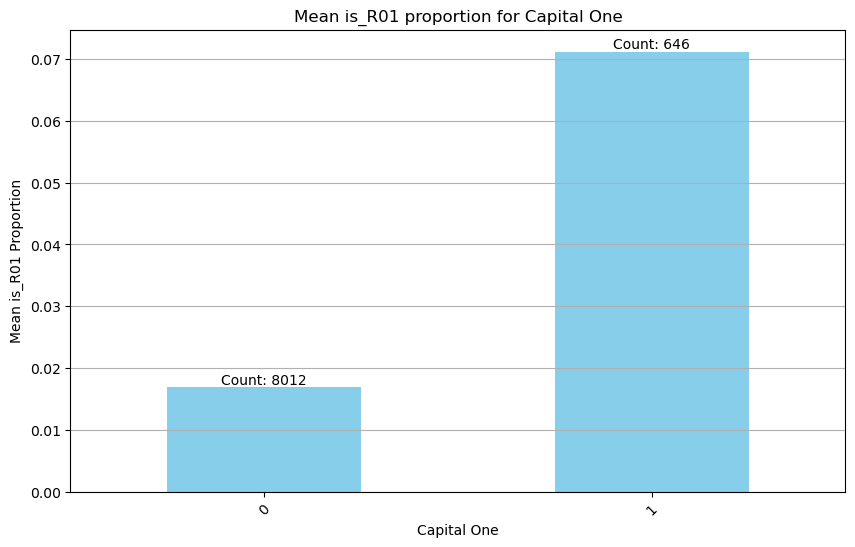

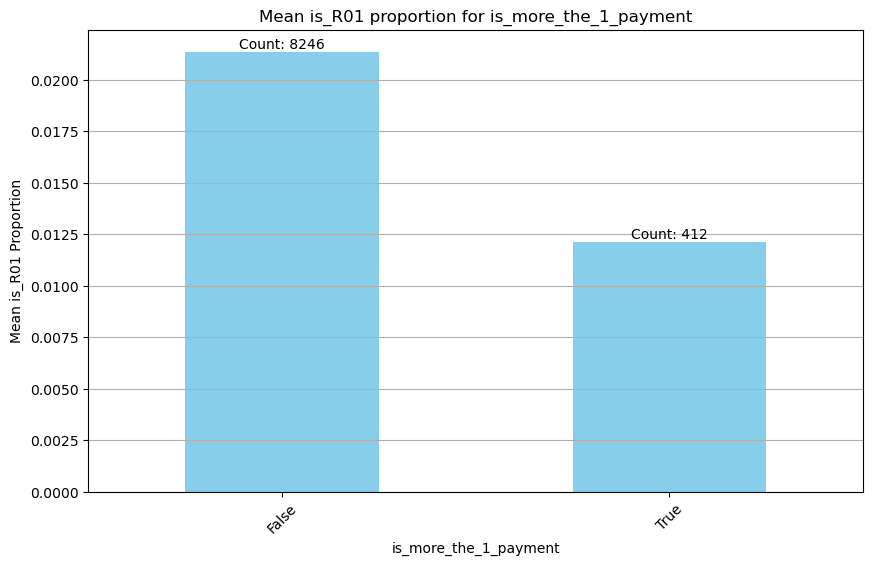

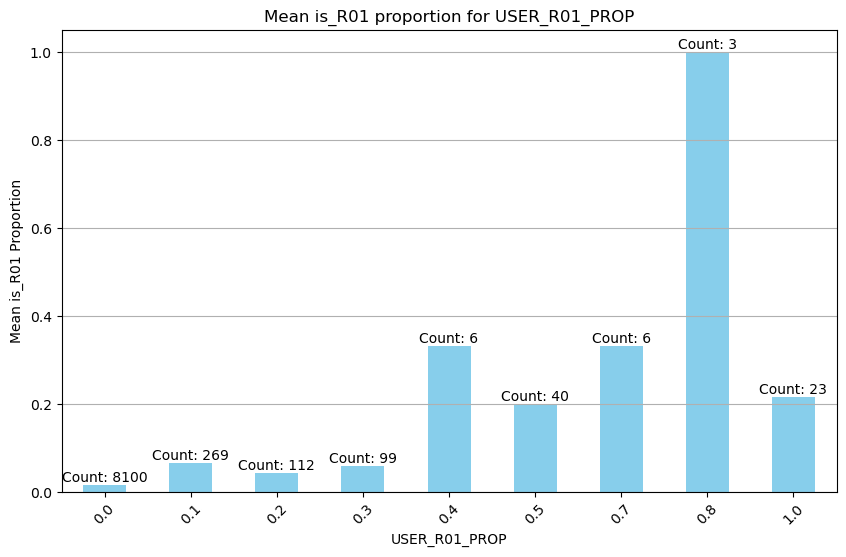

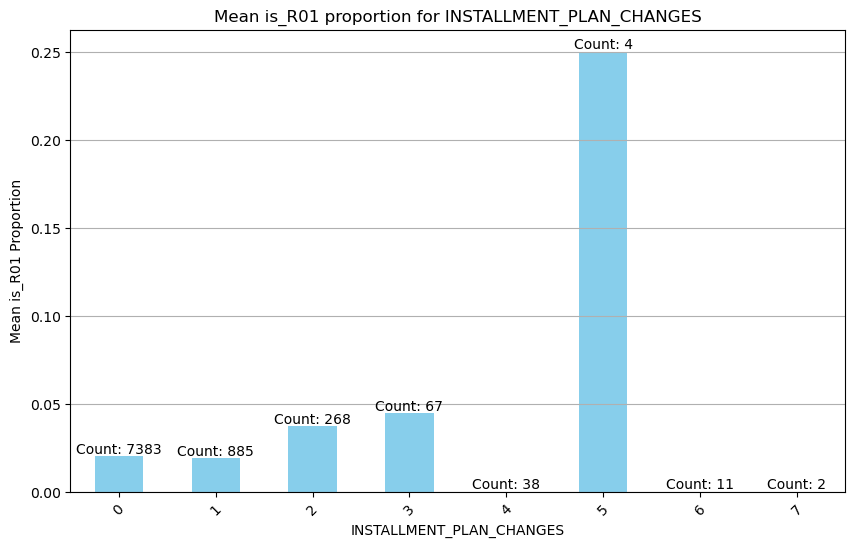

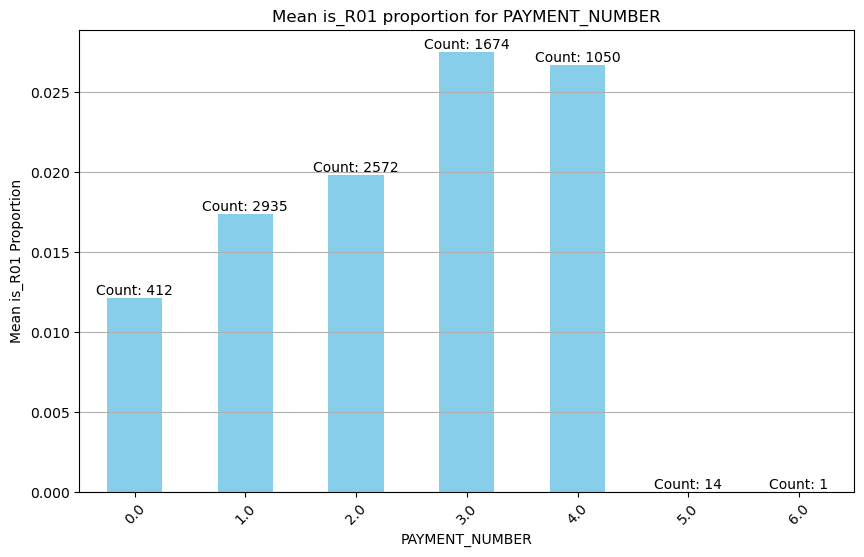

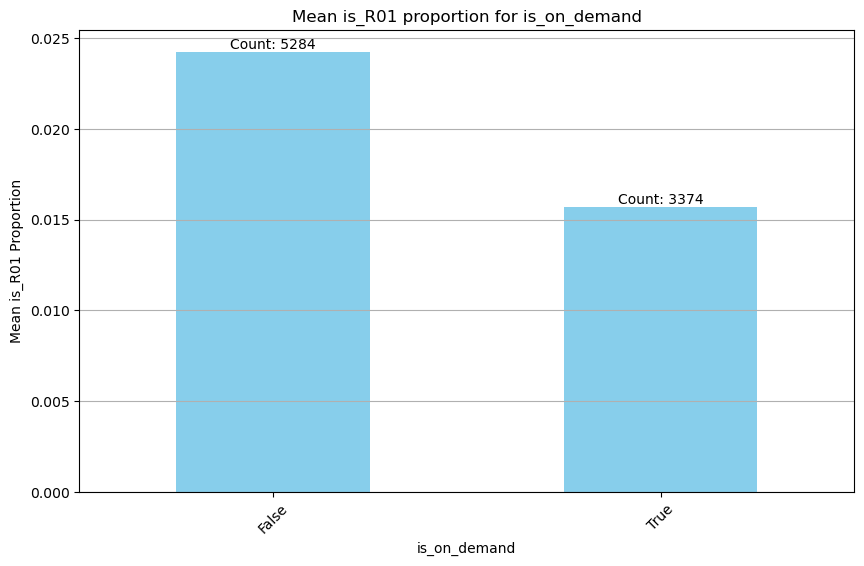

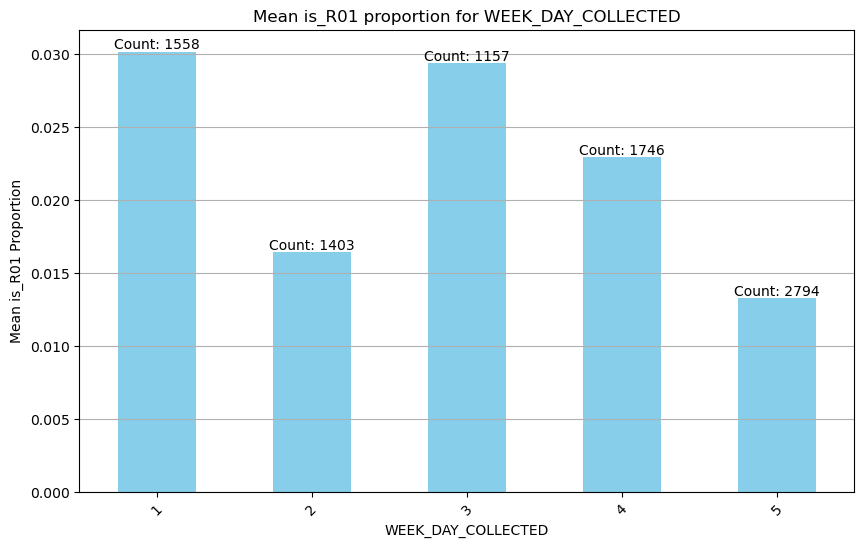

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter features with correlation to is_R01 greater than 0.1
relevant_features = ["DAYS_SINCE_PREVIOUS_REPAYMENT","DAYS_SINCE_NSF","DAYS_SINCE_SUCCEEDED_PAYMENT","DAYS_SINCE_FAILED_PAYMENT","balance_amount_ratio_bin","RENT_NSF_PROP","Capital One","is_more_the_1_payment", "USER_R01_PROP", "USER_NSF_PROP", "INSTALLMENT_PLAN_CHANGES", "PAYMENT_NUMBER", "is_on_demand", "WEEK_DAY_COLLECTED"]


# Plot proportion for features without binning
for feature in relevant_features:
    # Check if the feature has less than or equal to 5 unique values
    if len(df[feature].unique()) <= 10:
        mean_is_R01 = df.groupby(feature)['is_R01'].mean()
        count_is_R01 = df.groupby(feature)['is_R01'].count()

        plt.figure(figsize=(10, 6))
        ax = mean_is_R01.plot(kind='bar', color='skyblue')
        plt.title(f'Mean is_R01 proportion for {feature}')
        plt.xlabel(feature)
        plt.ylabel('Mean is_R01 Proportion')
        plt.xticks(rotation=45)
        plt.grid(axis='y')

        # Add counts above each bar
        for i, count in enumerate(count_is_R01):
            ax.text(i, mean_is_R01.iloc[i], f'Count: {count}', ha='center', va='bottom')

        plt.show()


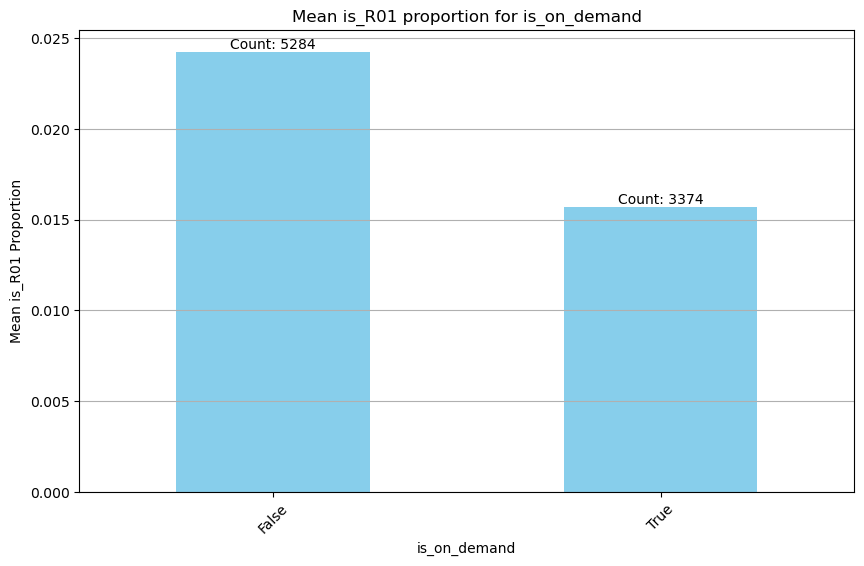

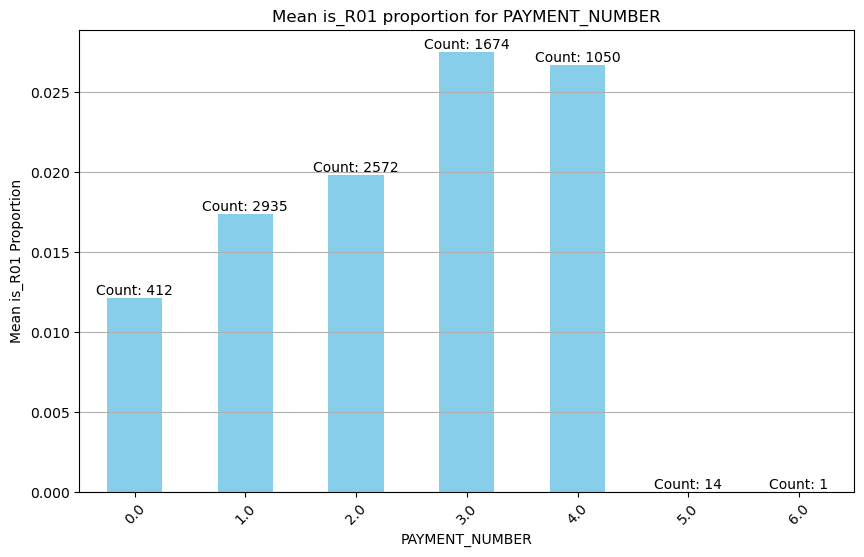

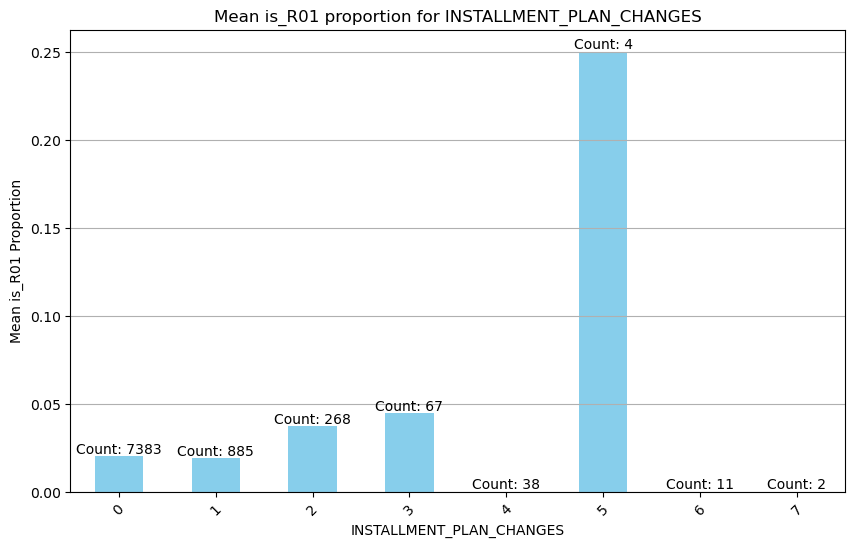

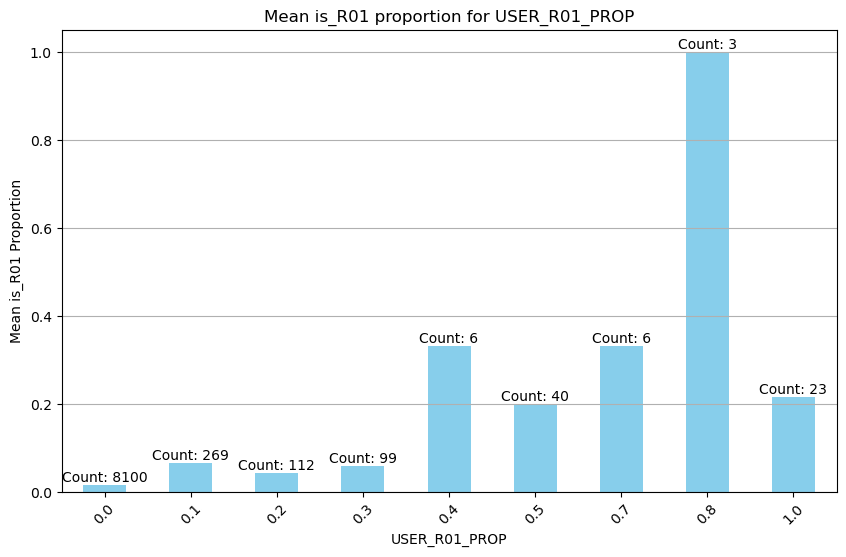

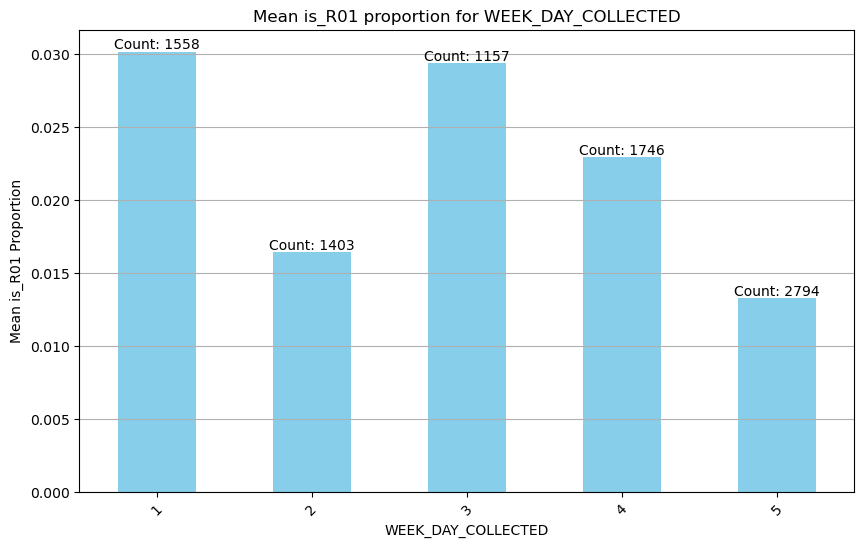

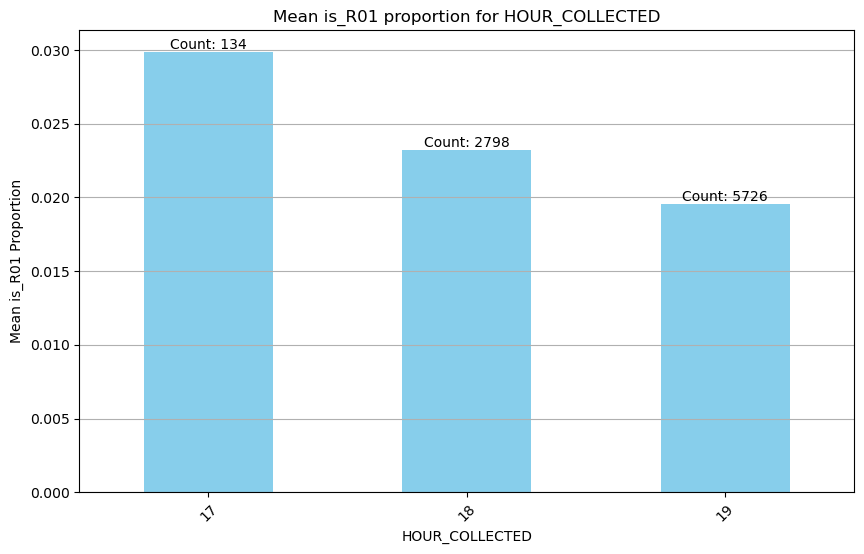

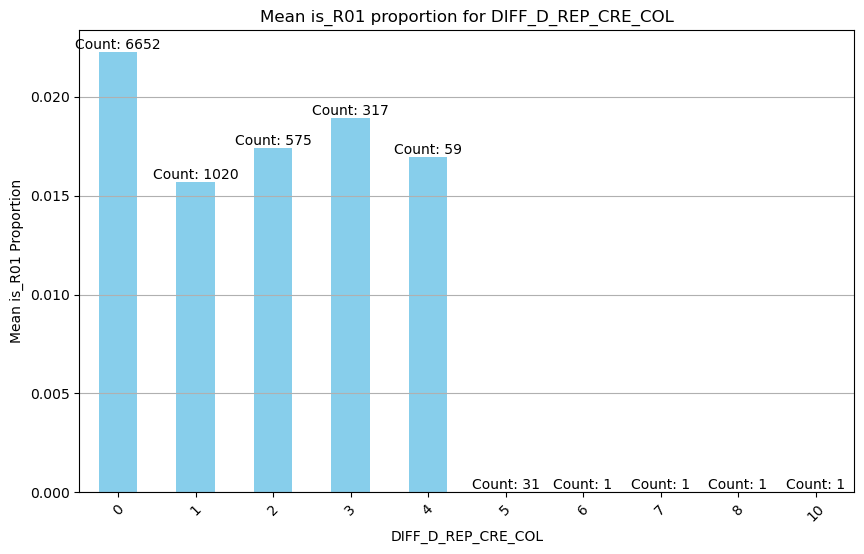

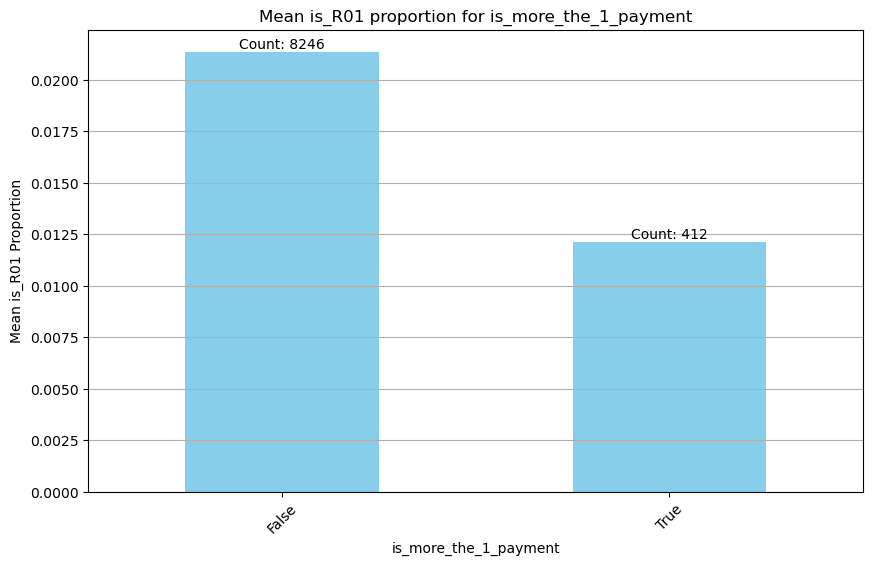

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter features with correlation to is_R01 greater than 0.1
relevant_features = ['is_on_demand', 'PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES', 
                   'USER_NSF_PROP', 'RENT_NSF_PROP', 'USER_R01_PROP', 'DAYS_SINCE_PREVIOUS_REPAYMENT', 
                   'WEEK_DAY_COLLECTED', 'HOUR_COLLECTED', 'AGE', 'DIFF_D_REP_BAL', 'DIFF_D_REP_RENT', 
                   'DIFF_D_REP_CRE_COL', 'is_more_the_1_payment']

# Plot proportion for features without binning
for feature in relevant_features:
    # Check if the feature has less than or equal to 5 unique values
    if len(df[feature].unique()) <= 10:
        mean_is_R01 = df.groupby(feature)['is_R01'].mean()
        count_is_R01 = df.groupby(feature)['is_R01'].count()

        plt.figure(figsize=(10, 6))
        ax = mean_is_R01.plot(kind='bar', color='skyblue')
        plt.title(f'Mean is_R01 proportion for {feature}')
        plt.xlabel(feature)
        plt.ylabel('Mean is_R01 Proportion')
        plt.xticks(rotation=45)
        plt.grid(axis='y')

        # Add counts above each bar
        for i, count in enumerate(count_is_R01):
            ax.text(i, mean_is_R01.iloc[i], f'Count: {count}', ha='center', va='bottom')

        plt.show()


# Forward feature selection 

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifier
clf = DecisionTreeClassifier()

# Initialize an empty list to store selected features
selected_features = []

# Perform forward feature selection
for i in range(15):  # Loop for 15 iterations or change as needed
    best_accuracy = 0
    best_feature = None
    
    # Iterate over remaining features
    for feature in X.columns:
        if feature not in selected_features:
            # Add the feature to the selected features
            current_features = selected_features + [feature]
            
            # Train the model using current selected features
            clf.fit(X_train[current_features], y_train)
            
            # Predict on the test set
            y_pred = clf.predict(X_test[current_features])
            
            # Compute accuracy
            accuracy = accuracy_score(y_test, y_pred)
            
            # Update best feature and accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
    
    # Add the best feature to the selected features list
    selected_features.append(best_feature)
    
    # Print selected features and accuracy for every 3 iterations
    if (i + 1) % 3 == 0:
        print(f"Iteration {i + 1}: Selected Features: {selected_features}, Accuracy: {best_accuracy}")
        print("-----------------------------------------------------------------------------------------")
# Print final selected features
print("\nFinal Selected Features:", selected_features)


Iteration 3: Selected Features: ['is_on_demand', 'is_more_the_1_payment', 'DIFF_D_REP_CRE_COL'], Accuracy: 0.9803695150115473
-----------------------------------------------------------------------------------------
Iteration 6: Selected Features: ['is_on_demand', 'is_more_the_1_payment', 'DIFF_D_REP_CRE_COL', 'DIFF_D_REP_RENT', 'PAYMENT_NUMBER', 'HOUR_COLLECTED'], Accuracy: 0.9815242494226328
-----------------------------------------------------------------------------------------
Iteration 9: Selected Features: ['is_on_demand', 'is_more_the_1_payment', 'DIFF_D_REP_CRE_COL', 'DIFF_D_REP_RENT', 'PAYMENT_NUMBER', 'HOUR_COLLECTED', 'INSTALLMENT_PLAN_CHANGES', 'DIFF_D_REP_BAL', 'WEEK_DAY_COLLECTED'], Accuracy: 0.9780600461893765
-----------------------------------------------------------------------------------------
Iteration 12: Selected Features: ['is_on_demand', 'is_more_the_1_payment', 'DIFF_D_REP_CRE_COL', 'DIFF_D_REP_RENT', 'PAYMENT_NUMBER', 'HOUR_COLLECTED', 'INSTALLMENT_PLAN_CHAN

In [63]:
featurs = ["PAYMENT_NUMBER"  , "INSTALLMENT_PLAN_CHANGES" , "USER_NSF_PROP" ,"USER_R01_PROP" , 'DAYS_SINCE_PREVIOUS_REPAYMENT', 'DAYS_SINCE_SUCCEEDED_PAYMENT',
       'DAYS_SINCE_FAILED_PAYMENT', 'DAYS_SINCE_NSF', 'WEEK_DAY_COLLECTED', 'AGE', 'is_more_the_1_payment' , 'balance_amount_ratio_bin' , 'is_on_demand' ]

# Final decision trees

In [64]:
X = df[featurs]
y = df.is_R01

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifier
clf = DecisionTreeClassifier()

# Initialize an empty list to store selected features
selected_features = []

# Perform forward feature selection
for i in range(10):  # Loop for 15 iterations or change as needed
    best_accuracy = 0
    best_feature = None
    
    # Iterate over remaining features
    for feature in X.columns:
        if feature not in selected_features:
            # Add the feature to the selected features
            current_features = selected_features + [feature]
            
            # Train the model using current selected features
            clf.fit(X_train[current_features], y_train)
            
            # Predict on the test set
            y_pred = clf.predict(X_test[current_features])
            
            # Compute accuracy
            accuracy = accuracy_score(y_test, y_pred)
            
            # Update best feature and accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
    
    # Add the best feature to the selected features list
    selected_features.append(best_feature)
    
    # Print selected features and accuracy for every 3 iterations
   
    print(f"Iteration {i + 1}: Selected Features: {selected_features}, Accuracy: {best_accuracy}")
    print("-----------------------------------------------------------------------------------------")
# Print final selected features
print("\nFinal Selected Features:", selected_features)


Iteration 1: Selected Features: ['PAYMENT_NUMBER'], Accuracy: 0.9803695150115473
-----------------------------------------------------------------------------------------
Iteration 2: Selected Features: ['PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES'], Accuracy: 0.9803695150115473
-----------------------------------------------------------------------------------------
Iteration 3: Selected Features: ['PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES', 'USER_R01_PROP'], Accuracy: 0.9803695150115473
-----------------------------------------------------------------------------------------
Iteration 4: Selected Features: ['PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES', 'USER_R01_PROP', 'WEEK_DAY_COLLECTED'], Accuracy: 0.98094688221709
-----------------------------------------------------------------------------------------
Iteration 5: Selected Features: ['PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES', 'USER_R01_PROP', 'WEEK_DAY_COLLECTED', 'is_more_the_1_payment'], Accuracy: 0.98094688221709
-------

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifier
clf = DecisionTreeClassifier()

# Initialize the list of features to keep with all features
features_to_keep = list(X.columns)

# Perform backward feature elimination until left with 2 features
while len(features_to_keep) > 2:
    # Initialize variables for the current iteration
    best_accuracy = 0
    feature_to_remove = None
    
    # Iterate over features to remove one feature at a time
    for feature in features_to_keep:
        # Create a copy of features to keep without the current feature
        current_features = features_to_keep.copy()
        current_features.remove(feature)
        
        # Train the classifier using current selected features
        clf.fit(X_train[current_features], y_train)
        
        # Predict on the test set
        y_pred = clf.predict(X_test[current_features])
        
        # Compute accuracy on the test set
        accuracy = accuracy_score(y_test, y_pred)
        
        # Update best accuracy and feature to remove
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            feature_to_remove = feature
    
    # Remove the selected feature from the list
    features_to_keep.remove(feature_to_remove)
    
    # Print the feature removed and its test accuracy in this iteration
    print("Removed feature:", feature_to_remove)
    print("Test Accuracy:", best_accuracy)
    print("Remaining Features:", features_to_keep)
    print("---------------------------------------")

# Print the final selected features
print("\nFinal Selected Features:", features_to_keep)


Removed feature: WEEK_DAY_COLLECTED
Test Accuracy: 0.9705542725173211
Remaining Features: ['PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES', 'USER_NSF_PROP', 'USER_R01_PROP', 'DAYS_SINCE_PREVIOUS_REPAYMENT', 'DAYS_SINCE_SUCCEEDED_PAYMENT', 'DAYS_SINCE_FAILED_PAYMENT', 'DAYS_SINCE_NSF', 'AGE', 'is_more_the_1_payment', 'balance_amount_ratio_bin', 'is_on_demand']
---------------------------------------
Removed feature: USER_NSF_PROP
Test Accuracy: 0.9734411085450346
Remaining Features: ['PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES', 'USER_R01_PROP', 'DAYS_SINCE_PREVIOUS_REPAYMENT', 'DAYS_SINCE_SUCCEEDED_PAYMENT', 'DAYS_SINCE_FAILED_PAYMENT', 'DAYS_SINCE_NSF', 'AGE', 'is_more_the_1_payment', 'balance_amount_ratio_bin', 'is_on_demand']
---------------------------------------
Removed feature: AGE
Test Accuracy: 0.9745958429561201
Remaining Features: ['PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES', 'USER_R01_PROP', 'DAYS_SINCE_PREVIOUS_REPAYMENT', 'DAYS_SINCE_SUCCEEDED_PAYMENT', 'DAYS_SINCE_FAILED_P

In [109]:
best_model = DecisionTreeClassifier(max_depth=best_hyperparameters['max_depth'],
                                    min_samples_split=best_hyperparameters['min_samples_split'])
best_model.fit(X, y)
feat_imp_dict ={}
for i,j in zip(best_model.feature_names_in_ ,best_model.feature_importances_):
    feat_imp_dict[i] = j
sorted_feat_imp = sorted(feat_imp_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feat_imp

[('AGE', 0.1608107191246247),
 ('balance_amount_ratio_bin', 0.14767217628368487),
 ('PAYMENT_NUMBER', 0.1342871100675999),
 ('DAYS_SINCE_FAILED_PAYMENT', 0.12088669274998785),
 ('USER_NSF_PROP', 0.0990133049631518),
 ('DAYS_SINCE_PREVIOUS_REPAYMENT', 0.06784702277180873),
 ('WEEK_DAY_COLLECTED', 0.0640503898240434),
 ('USER_R01_PROP', 0.06049546718693874),
 ('INSTALLMENT_PLAN_CHANGES', 0.05126997737184626),
 ('DAYS_SINCE_NSF', 0.04253473010195133),
 ('is_on_demand', 0.03881853834948293),
 ('is_more_the_1_payment', 0.008725523113207142),
 ('DAYS_SINCE_SUCCEEDED_PAYMENT', 0.0035883480916724083)]

In [66]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to Graphviz format
dot_data = export_graphviz(best_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['Not R01', 'R01'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the decision tree
graph = graphviz.Source(dot_data)  
graph.render("decision_tree_limited2")  # Save the tree as PDF or any other format


ValueError: Length of feature_names, 13 does not match number of features, 60

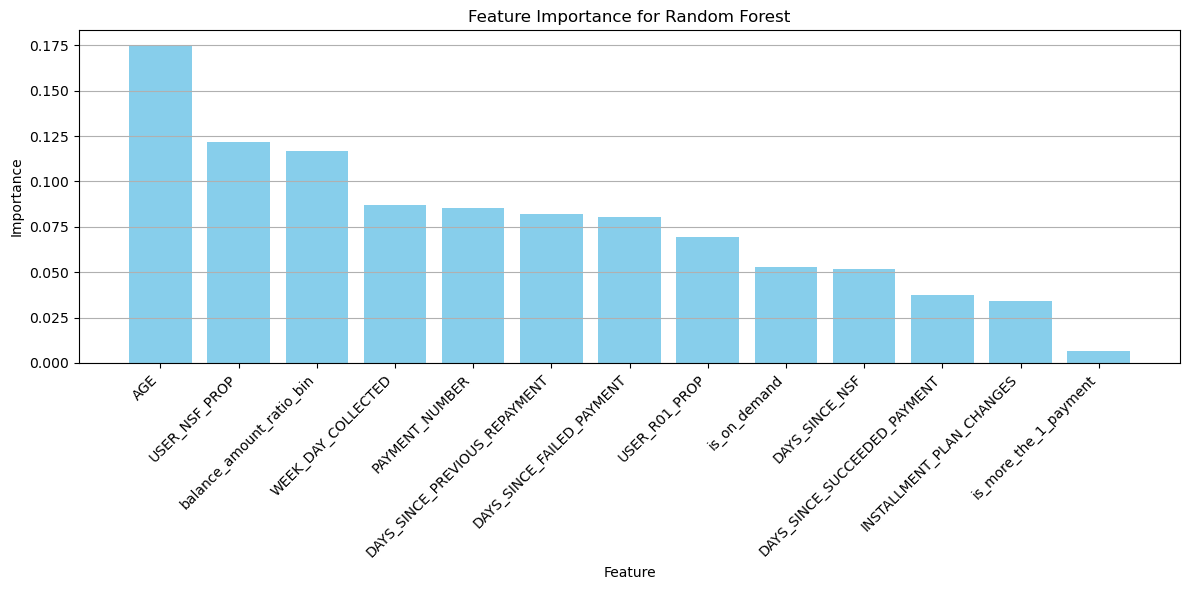

Accuracy on test data: 0.98094688221709
F1 score on test data: 0.26666666666666666


In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.grid(axis='y')
plt.show()

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print accuracy and F1 score
print("Accuracy on test data:", accuracy)
print("F1 score on test data:", f1)


 # Last try - limited features backward - drop Bug R01

In [67]:
subset_mini = ['INSTALLMENT_PLAN_CHANGES', 'balance_amount_ratio_bin','DAYS_SINCE_PREVIOUS_REPAYMENT', 'DAYS_SINCE_SUCCEEDED_PAYMENT', 'DAYS_SINCE_NSF', 'is_on_demand']

In [68]:
subset_full = ['INSTALLMENT_PLAN_CHANGES', 'USER_R01_PROP', 'balance_amount_ratio_bin', 'DAYS_SINCE_PREVIOUS_REPAYMENT', 'DAYS_SINCE_SUCCEEDED_PAYMENT', 'DAYS_SINCE_FAILED_PAYMENT', 'DAYS_SINCE_NSF', 'is_more_the_1_payment', 'is_on_demand']

## SHOW URI

In [79]:
df.is_R01[(df.BALANCE - df.AMOUNT) < 0 ].mean() , df.is_R01[df.balance_amount_ratio_bin < 1].mean() 

(0.26666666666666666, 0.2857142857142857)

In [109]:
df_no_bug_users = df[~ (df.balance_amount_ratio_bin < 1)]

In [83]:
df.is_R01.mean()

0.020905520905520905

In [82]:
df_no_bug_users.is_R01.sum() , df_no_bug_users.is_R01.mean()

(173, 0.020046349942062572)

## MINI 

In [85]:
X = df_no_bug_users[subset_mini]
y = df_no_bug_users.is_R01

simple_model = DecisionTreeClassifier(max_depth=6,min_samples_leaf=5)
simple_model.fit(X,y)



# Export the decision tree to Graphviz format
dot_data = export_graphviz(simple_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['Not R01', 'R01'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the decision tree
graph = graphviz.Source(dot_data)  
graph.render("SUBSET_MINI_BEST_FEAT_SIMPLE_MODEL")  # Save the tree as PDF or any other format


'SUBSET_MINI_BEST_FEAT_SIMPLE_MODEL.pdf'

## MID

In [86]:
X = df_no_bug_users[subset_full]
y = df_no_bug_users.is_R01


simple_model = DecisionTreeClassifier( max_depth=6 , min_samples_leaf= 5 )
simple_model.fit(X,y)


# Export the decision tree to Graphviz format
dot_data = export_graphviz(simple_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['Not R01', 'R01'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the decision tree
graph = graphviz.Source(dot_data)  
graph.render("SUBSET_MID_BEST_FEAT_SIMPLE_MODEL")  # Save the tree as PDF or any other format

'SUBSET_MID_BEST_FEAT_SIMPLE_MODEL.pdf'

## FULL

In [91]:
X = df_no_bug_users.drop(columns="is_R01")
y = df_no_bug_users.is_R01


simple_model = DecisionTreeClassifier(max_depth=6,min_samples_leaf=5)
simple_model.fit(X,y)

# Export the decision tree to Graphviz format
dot_data = export_graphviz(simple_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['Not R01', 'R01'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the decision tree
graph = graphviz.Source(dot_data)  
graph.render("SUBSET_FULL_BEST_FEAT_SIMPLE_MODEL")  # Save the tree as PDF or any other format

'SUBSET_FULL_BEST_FEAT_SIMPLE_MODEL.pdf'

# Policy check

In [93]:
df_no_bug_users.columns

Index(['AMOUNT', 'BALANCE', 'PAYMENT_NUMBER', 'INSTALLMENT_PLAN_CHANGES',
       'USER_NSF_PROP', 'RENT_NSF_PROP', 'USER_R01_PROP',
       'DAYS_SINCE_PREVIOUS_REPAYMENT', 'DAYS_SINCE_SUCCEEDED_PAYMENT',
       'DAYS_SINCE_FAILED_PAYMENT', 'DAYS_SINCE_NSF', 'WEEK_DAY_COLLECTED',
       'HOUR_COLLECTED', 'AGE', 'DIFF_D_REP_BAL', 'DIFF_D_REP_RENT',
       'DIFF_D_REP_CRE_COL', 'is_R01', 'is_more_the_1_payment',
       'Bank of America', 'Capital One', 'Chase', 'Chime', 'Huntington Bank',
       'Navy Federal Credit Union', 'Regions Bank', 'SoFi', 'TD Bank',
       'Truist', 'USAA', 'Wells Fargo', 'other_institution', 'is_on_demand',
       'CA', 'FL', 'GA', 'IL', 'IN', 'MD', 'NC', 'NJ', 'NY', 'OH', 'PA', 'SC',
       'TN', 'TX', 'VA', 'WA', 'missing', 'other_state', 'active_building',
       'appfolio', 'click_pay', 'managego', 'pay_rent', 'rent_manager',
       'turbo_tenant', 'zego', 'balance_amount_ratio',
       'balance_amount_ratio_bin'],
      dtype='object')

## case 1 

In [119]:
case_1_r01 = df_no_bug_users.is_R01[(df_no_bug_users.DAYS_SINCE_FAILED_PAYMENT < 5) & (df_no_bug_users["Capital One"] < 0.5) & (df_no_bug_users.BALANCE <= 17923.5) & (df_no_bug_users.USER_NSF_PROP > 0.5)]

print("R01s amount: ", case_1_r01.sum() ," R01s propotion: ", case_1_r01.mean())

R01s amount:  6  R01s propotion:  0.8571428571428571


## case 2 

In [120]:
case_2_r01 = df_no_bug_users.is_R01[(df_no_bug_users.DAYS_SINCE_FAILED_PAYMENT < 5) & (df_no_bug_users["Capital One"] > 0.5) &  (df_no_bug_users.DIFF_D_REP_RENT > 28)]
print("R01s amount: ", case_2_r01.sum() ," R01s propotion: ", case_2_r01.mean())

R01s amount:  12  R01s propotion:  0.8


## case 3

In [123]:
case_3_r01 = df_no_bug_users.is_R01[(df_no_bug_users.DAYS_SINCE_FAILED_PAYMENT < 5) & (df_no_bug_users["Capital One"] > 0.5) &  (df_no_bug_users.DIFF_D_REP_RENT <= 28) & ((df_no_bug_users.appfolio > 0.5)|(df_no_bug_users.AGE <= 34))]
print("R01s amount: ", case_3_r01.sum() ," R01s propotion: ", case_3_r01.mean())

R01s amount:  10  R01s propotion:  0.5


## case 4

In [129]:
case_4_r01 = df_no_bug_users.is_R01[(df_no_bug_users.DAYS_SINCE_FAILED_PAYMENT >= 5) & (df_no_bug_users.DAYS_SINCE_PREVIOUS_REPAYMENT <= 2.5) & (df_no_bug_users.RENT_NSF_PROP <= 0.1) & (df_no_bug_users.balance_amount_ratio <= 1.459 ) & (df_no_bug_users.balance_amount_ratio < 1.061) & (df_no_bug_users.balance_amount_ratio > 1.035 )]
print("R01s amount: ", case_4_r01.sum() ," R01s propotion: ", case_4_r01.mean())

R01s amount:  8  R01s propotion:  1.0


## case 5

In [143]:
case_4_r01 = df_no_bug_users.is_R01[(df_no_bug_users.DAYS_SINCE_FAILED_PAYMENT >= 5) & (df_no_bug_users.DAYS_SINCE_PREVIOUS_REPAYMENT <= 2.5) & (df_no_bug_users.RENT_NSF_PROP <= 0.1) & (df_no_bug_users.balance_amount_ratio <= 1.459 ) & (df_no_bug_users.balance_amount_ratio > 1.061) & (df_no_bug_users.USER_NSF_PROP >= 0.15)] 
print("R01s amount: ", case_4_r01.sum() ," R01s propotion: ", case_4_r01.mean())

R01s amount:  4  R01s propotion:  0.6666666666666666


## case 6

In [140]:
case_6_r01 = df_no_bug_users.is_R01[(df_no_bug_users.DAYS_SINCE_FAILED_PAYMENT >= 5) & (df_no_bug_users.DAYS_SINCE_PREVIOUS_REPAYMENT <= 2.5) & (df_no_bug_users.RENT_NSF_PROP > 0.1) & (df_no_bug_users.balance_amount_ratio < 1.459 ) & (df_no_bug_users.DIFF_D_REP_CRE_COL < 1) & (df_no_bug_users.WEEK_DAY_COLLECTED <= 2.5) ]
print("R01s amount: ", case_6_r01.sum() ," R01s propotion: ", case_6_r01.mean())

R01s amount:  7  R01s propotion:  0.5833333333333334
